In [1]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets as nets

tf.logging.set_verbosity(tf.logging.ERROR)
sess = tf.InteractiveSession()

In [2]:
#设置输入图像，使用tf.Variable而不是使用tf.placeholder,这是因为要确保它是
#可训练的，当我们需要时，仍可以输入它。
image = tf.Variable(tf.zeros((299, 299, 3)))

In [3]:
#加载inception v3模型
def inception(image, reuse):
    preprocessed = tf.multiply(tf.subtract(tf.expand_dims(image, 0), 0.5), 2.0)
    arg_scope = nets.inception.inception_v3_arg_scope(weight_decay=0.0)
    with slim.arg_scope(arg_scope):
        logits, _ = nets.inception.inception_v3(preprocessed,
                                                1001,
                                                is_training=False,
                                                reuse=reuse)
        logits = logits[:, 1:]  #ignore background class
        probs = tf.nn.softmax(logits)  #probabilities
    return logits, probs


logits, probs = inception(image, reuse=False)

In [4]:
#加载预训练的权重
import tempfile
from urllib.request import urlretrieve
import tarfile
import os
data_dir = tempfile.mkdtemp()
inception_tarball, _ = urlretrieve(
    'http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz')
tarfile.open(inception_tarball, 'r:gz').extractall(data_dir)
restore_vars = [
    var for var in tf.global_variables() if var.name.startswith('InceptionV3/')
]
saver = tf.train.Saver(restore_vars)
saver.restore(sess, os.path.join(data_dir, 'inception_v3.ckpt'))

In [5]:
#显示图像，并对它进行分类以及显示分类结果
import json
import matplotlib.pyplot as plt
imagenet_json, _ = urlretrieve(
    'http://www.anishathalye.com/media/2017/07/25/imagenet.json')
with open(imagenet_json) as f:
    imagenet_labels = json.load(f)


def classify(img, correct_class=None, target_class=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
    fig.sca(ax1)
    p = sess.run(probs, feed_dict={image: img})[0]
    ax1.imshow(img)
    fig.sca(ax1)

    topk = list(p.argsort()[-10:][::-1])
    topprobs = p[topk]
    barlist = ax2.bar(range(10), topprobs)
    if target_class in topk:
        barlist[topk.index(target_class)].set_color('r')
    if correct_class in topk:
        barlist[topk.index(correct_class)].set_color('g')
    plt.sca(ax2)
    plt.ylim([0, 1.1])
    plt.xticks(range(10), [imagenet_labels[i][:15] for i in topk],
               rotation='vertical')
    fig.subplots_adjust(bottom=0.2)
    plt.show()

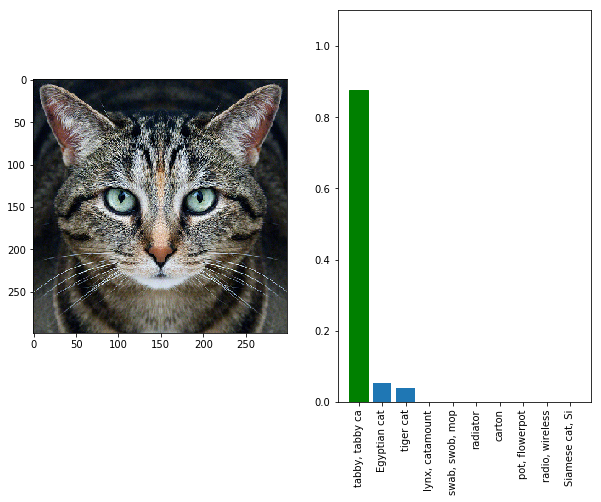

In [6]:
#加载示例图像，并确保它已被正确分类
import PIL
import numpy as np
img_path, _ = urlretrieve('http://www.anishathalye.com/media/2017/07/25/cat.jpg')
img_class = 281
img = PIL.Image.open(img_path)
big_dim = max(img.width, img.height)
wide = img.width > img.height
new_w = 299 if not wide else int(img.width * 299 / img.height)
new_h = 299 if wide else int(img.height * 299 / img.width)
img = img.resize((new_w, new_h)).crop((0, 0, 299, 299))
img = (np.asarray(img) / 255.0).astype(np.float32)
classify(img, correct_class=img_class)